In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

training_set = pd.read_csv('Dataset/fashion_data/fashion-mnist_train.csv')
test_set = pd.read_csv('Dataset/fashion_data/fashion-mnist_test.csv')

print(training_set.shape)
print(test_set.shape)

(60000, 785)
(10000, 785)


In [118]:
# Preprocess Dataset
y_train = training_set.iloc[:, 0].to_numpy()
X_train = training_set.iloc[:, 1:].to_numpy()
y_test = test_set.iloc[:, 0].to_numpy()
X_test = test_set.iloc[:, 1:].to_numpy()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60000, 784)
y_train shape: (60000,)
X_test shape: (10000, 784)
y_test shape: (10000,)


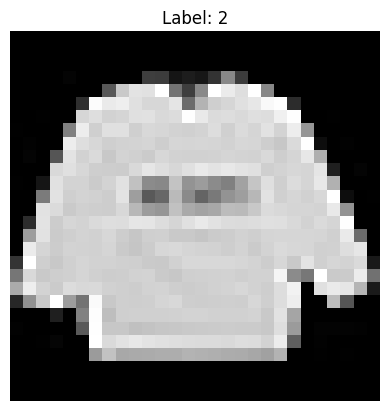

In [119]:
# Visualize an example image
image_array = X_train[0].reshape(28, 28)  # Reshape from 784 to 28x28
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {y_train[0]}")
plt.axis('off')
plt.show()

In [120]:
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0
# One-hot encode labels
y_train = pd.get_dummies(y_train).to_numpy()
y_test = pd.get_dummies(y_test).to_numpy()
print("One-hot encoded y_train shape:", y_train.shape)

One-hot encoded y_train shape: (60000, 10)


In [121]:
# Activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return (x > 0).astype(float)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)

def softmax_derivative(a_out, y_true):
    return a_out - y_true  # Gradient for softmax combined with cross-entropy

In [122]:
# Dropout function (Inverted Dropout)
def apply_dropout(a, dropout_rate):
    mask = (np.random.rand(*a.shape) > dropout_rate).astype(float)
    return a * mask / (1 - dropout_rate), mask

In [123]:
#Loss function
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[0]
    return -np.sum(y_true * np.log(y_pred + 1e-9)) / m

In [124]:
class NeuralNetwork:
    def __init__(self, layers, activations, dropout_rates=None):
        self.layers = layers
        self.activations = activations
        self.dropout_rates = dropout_rates if dropout_rates else [0] * (len(layers) - 1)
        self.weights = []
        self.biases = []

        # Initialize weights and biases
        for i in range(len(layers) - 1):
            self.weights.append(np.random.randn(layers[i], layers[i + 1]) * 0.01)
            self.biases.append(np.zeros((1, layers[i + 1])))

    def activation(self, x, activation_type):
        if activation_type == 'relu':
            return relu(x)
        elif activation_type == 'sigmoid':
            return sigmoid(x)
        elif activation_type == 'softmax':
            return softmax(x)
        else:
            raise ValueError("Unsupported activation function")

    def activation_derivative(self, x, activation_type):
        if activation_type == 'relu':
            return relu_derivative(x)
        elif activation_type == 'sigmoid':
            return sigmoid_derivative(x)
        else:
            raise ValueError("Unsupported activation function")
    def forward(self, X):
        a = X
        cache = {'a0': a}

        for i in range(len(self.weights)):
            z = np.dot(a, self.weights[i]) + self.biases[i]
            a = self.activation(z, self.activations[i])
            if self.dropout_rates[i] > 0:
                a, mask = apply_dropout(a, self.dropout_rates[i])
                cache[f'mask{i}'] = mask
            cache[f'z{i + 1}'] = z
            cache[f'a{i + 1}'] = a

        return a, cache
    def backward(self, X, y, cache):
        m = y.shape[0]
        gradients = {}

        # Output layer
        a_out = cache[f'a{len(self.weights)}']
        dz = a_out - y

        for i in reversed(range(len(self.weights))):
            gradients[f'dw{i + 1}'] = np.dot(cache[f'a{i}'].T, dz) / m
            gradients[f'db{i + 1}'] = np.sum(dz, axis=0, keepdims=True) / m

            if i > 0:
                da = np.dot(dz, self.weights[i].T)
                dz = da * self.activation_derivative(cache[f'z{i}'], self.activations[i - 1])
                if self.dropout_rates[i - 1] > 0:
                    dz *= cache[f'mask{i - 1}'] / (1 - self.dropout_rates[i - 1])

        return gradients

    def update_weights(self, gradients, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * gradients[f'dw{i + 1}']
            self.biases[i] -= learning_rate * gradients[f'db{i + 1}']

In [125]:
# SGD Optimizer
def sgd(nn, X, y, epochs, batch_size, learning_rate):
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        epoch_loss = 0
        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Forward and backward pass
            y_pred, cache = nn.forward(X_batch)
            gradients = nn.backward(X_batch, y_batch, cache)

            # Update weights
            nn.update_weights(gradients, learning_rate)

            # Calculate batch loss
            batch_loss = cross_entropy_loss(y_batch, y_pred)
            epoch_loss += batch_loss

        # Store average loss for the epoch
        training_losses.append(epoch_loss / (X.shape[0] // batch_size))

        # Compute validation loss
        val_pred, _ = nn.forward(X_test)
        val_loss = cross_entropy_loss(y_test, val_pred)
        validation_losses.append(val_loss)

    return training_losses, validation_losses

In [126]:
# SGD with Momentum
def sgd_with_momentum(nn, X, y, epochs, batch_size, learning_rate, momentum=0.9):
    velocity_w = [np.zeros_like(w) for w in nn.weights]
    velocity_b = [np.zeros_like(b) for b in nn.biases]
    training_losses = []
    validation_losses = []

    for epoch in range(epochs):
        permutation = np.random.permutation(X.shape[0])
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        epoch_loss = 0
        for i in range(0, X.shape[0], batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Forward and backward pass
            y_pred, cache = nn.forward(X_batch)
            gradients = nn.backward(X_batch, y_batch, cache)

            for j in range(len(nn.weights)):
                velocity_w[j] = momentum * velocity_w[j] - learning_rate * gradients[f'dw{j + 1}']
                velocity_b[j] = momentum * velocity_b[j] - learning_rate * gradients[f'db{j + 1}']
                nn.weights[j] += velocity_w[j]
                nn.biases[j] += velocity_b[j]

            # Calculate batch loss
            batch_loss = cross_entropy_loss(y_batch, y_pred)
            epoch_loss += batch_loss

        # Store average loss for the epoch
        training_losses.append(epoch_loss / (X.shape[0] // batch_size))

        # Compute validation loss
        val_pred, _ = nn.forward(X_test)
        val_loss = cross_entropy_loss(y_test, val_pred)
        validation_losses.append(val_loss)

    return training_losses, validation_losses


In [131]:
# Define the architecture and activation functions
layers = [X_train.shape[1], 600, 300, 100, 50, 10]
activations = ['relu', 'relu', 'relu', 'relu', 'softmax']
dropout_rates = [0.2, 0.2, 0.2, 0, 0]  # Optional dropout
nn = NeuralNetwork(layers, activations, dropout_rates)

In [132]:
# Train the model using SGD
#sgd(nn, X_train, y_train, epochs=10, batch_size=64, learning_rate=0.01)

In [139]:
# Train the model using SGD with Momentum
training_losses, validation_losses = sgd_with_momentum(nn, X_train, y_train, epochs=100, batch_size=128, learning_rate=0.01, momentum=0.9)

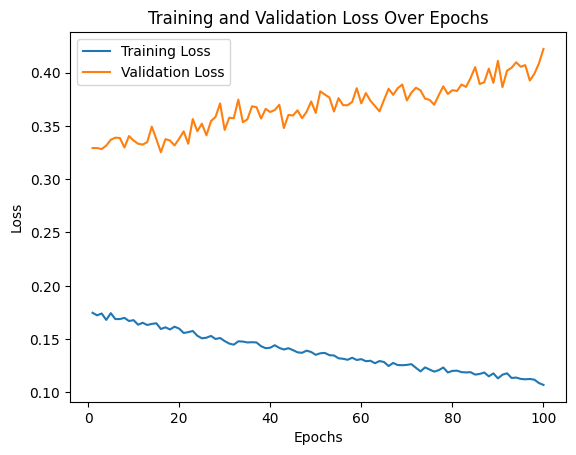

In [140]:
# Plot Training and Validation Loss
plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [141]:
# Evaluate performance on test set
y_pred, _ = nn.forward(X_test)
accuracy = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1))
print("Test Accuracy:", accuracy)


Test Accuracy: 0.8939
